In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from plotly import express as px

import warnings
warnings.filterwarnings("ignore")

In [2]:
generation = pd.read_csv(r"https://raw.githubusercontent.com/NickBianciardi/Solar_Vigilantes_spotting-outliers-in-PV-generation-data/main/Plant_2_Generation_Data.csv")
generation.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,2020-05-15 00:00:00,4136001,4UPUqMRk7TRMgml,0.0,0.0,9425.000000,2.429011e+06
1,2020-05-15 00:00:00,4136001,81aHJ1q11NBPMrL,0.0,0.0,0.000000,1.215279e+09
2,2020-05-15 00:00:00,4136001,9kRcWv60rDACzjR,0.0,0.0,3075.333333,2.247720e+09
3,2020-05-15 00:00:00,4136001,Et9kgGMDl729KT4,0.0,0.0,269.933333,1.704250e+06
4,2020-05-15 00:00:00,4136001,IQ2d7wF4YD8zU1Q,0.0,0.0,3177.000000,1.994153e+07


In [3]:
generation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67698 entries, 0 to 67697
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    67698 non-null  object 
 1   PLANT_ID     67698 non-null  int64  
 2   SOURCE_KEY   67698 non-null  object 
 3   DC_POWER     67698 non-null  float64
 4   AC_POWER     67698 non-null  float64
 5   DAILY_YIELD  67698 non-null  float64
 6   TOTAL_YIELD  67698 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.6+ MB


In [4]:
generation['convertion'] = (generation.AC_POWER/generation.DC_POWER).fillna(0)
generation.loc[generation.convertion>1, 'convertion'] = 1
generation['DATE_TIME'] = pd.to_datetime(generation['DATE_TIME'])
generation['date'] = generation['DATE_TIME'].dt.date
generation['month'] = generation['DATE_TIME'].dt.month
generation['day#'] = generation['DATE_TIME'].dt.day
generation['day'] = generation['DATE_TIME'].dt.strftime('%A')
generation['time'] = generation['DATE_TIME'].dt.time

In [5]:
generation.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,convertion,date,month,day#,day,time
0,2020-05-15,4136001,4UPUqMRk7TRMgml,0.0,0.0,9425.000000,2.429011e+06,0.0,2020-05-15,5,15,Friday,00:00:00
1,2020-05-15,4136001,81aHJ1q11NBPMrL,0.0,0.0,0.000000,1.215279e+09,0.0,2020-05-15,5,15,Friday,00:00:00
2,2020-05-15,4136001,9kRcWv60rDACzjR,0.0,0.0,3075.333333,2.247720e+09,0.0,2020-05-15,5,15,Friday,00:00:00
3,2020-05-15,4136001,Et9kgGMDl729KT4,0.0,0.0,269.933333,1.704250e+06,0.0,2020-05-15,5,15,Friday,00:00:00
4,2020-05-15,4136001,IQ2d7wF4YD8zU1Q,0.0,0.0,3177.000000,1.994153e+07,0.0,2020-05-15,5,15,Friday,00:00:00


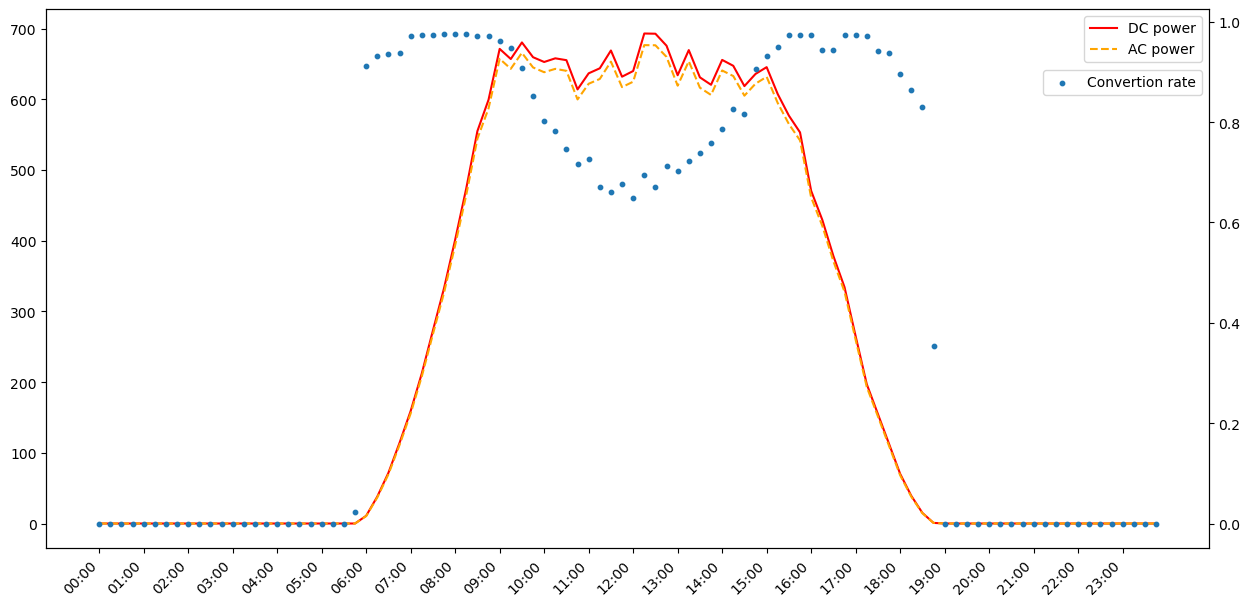

In [6]:
DC = generation.groupby(['time']).DC_POWER.mean().reset_index()
AC = generation.groupby(['time']).AC_POWER.mean().reset_index()
convertion = generation.groupby(['time']).convertion.mean().reset_index()

plt.figure(figsize=(15,7))
plt.plot(DC.time.astype('str'), DC.DC_POWER, label = 'DC power', color='red')
plt.plot(AC.time.astype('str'), AC.AC_POWER, label = 'AC power', color='orange', linestyle = '--')

# tick locations
ticks = plt.xticks()[0]
# only show one label every four ticks
selected_ticks = ticks[::4]
selected_labels = [label[:5] for label in DC.time.astype('str')][::4]
plt.xticks(selected_ticks, selected_labels, rotation=45, ha='right')
plt.legend()

plt.twinx()
plt.scatter(convertion.time.astype('str'), convertion.convertion, label = 'Convertion rate', s=10)
plt.legend(bbox_to_anchor=(1, 0.9))

plt.show()

Convertion of DC to AC current should be constant through time and close to 93-97%, its drop at sunlight peak hours (9am-2:45pm) indicates that there have been either some failures or the inverters have been turned off (maybe for maintenance purposes)

In [7]:
from datetime import time
print(f'There are {generation.SOURCE_KEY.nunique()} inverters in the power plant')
print(f'There are {generation[(generation.time>=time(9,0,0))&(generation.time<=time(15,0,0))&(generation.convertion<=0.9)].SOURCE_KEY.nunique()} inverters that have underperformed due to malfunctions or failures between 9am and 3:00pm')

There are 22 inverters in the power plant
There are 22 inverters that have underperformed due to malfunctions or failures between 9am and 3:00pm


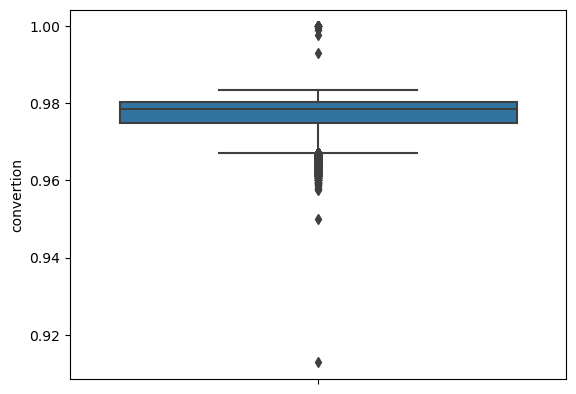

In [8]:
sns.boxplot(data=generation[generation.DC_POWER!=0], y='convertion')
plt.show()

In [9]:
max_time_gen = generation[generation.DC_POWER!=0].DATE_TIME.max()
min_time_gen = generation[generation.DC_POWER!=0].DATE_TIME.min()

print(f'Latest time of power generation: {max_time_gen}')
print(f'Earliest time of power generation: {min_time_gen}')

Latest time of power generation: 2020-06-17 18:45:00
Earliest time of power generation: 2020-05-15 06:00:00


In [10]:
daily_means = []
for date in generation.date.unique():
    daily_mean = generation[generation.date==date].DC_POWER.mean()
    daily_means.append(daily_mean)
daily_means = pd.DataFrame(daily_means, columns = ['mean_'], index = [generation.date.unique()])
mean_of_means = daily_means.mean_.mean()

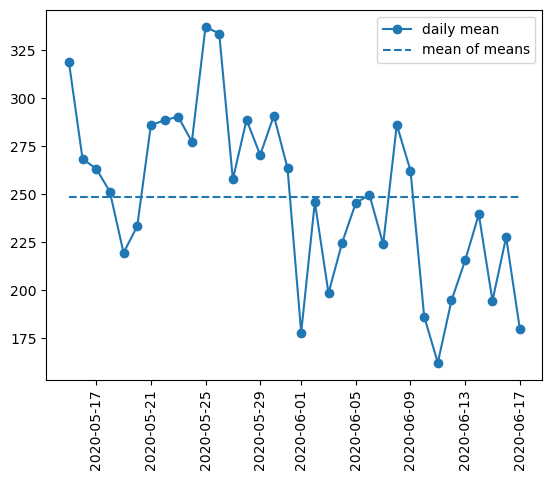

In [11]:
plt.plot(daily_means.reset_index().level_0, daily_means.mean_, marker='o', label = 'daily mean')
plt.hlines(y=mean_of_means, xmin=daily_means.reset_index().level_0.min(), 
           xmax=daily_means.reset_index().level_0.max(), linestyle = '--', 
          label = 'mean of means')
plt.legend()
plt.xticks(rotation=90)
plt.show()

Now let's integrate weather data so that we can better grasp the meaning of anomalies in DC power generation

In [12]:
weather = pd.read_csv(r"https://raw.githubusercontent.com/NickBianciardi/Solar_Vigilantes_spotting-outliers-in-PV-generation-data/main/Plant_2_Weather_Sensor_Data.csv")
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3259 entries, 0 to 3258
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE_TIME            3259 non-null   object 
 1   PLANT_ID             3259 non-null   int64  
 2   SOURCE_KEY           3259 non-null   object 
 3   AMBIENT_TEMPERATURE  3259 non-null   float64
 4   MODULE_TEMPERATURE   3259 non-null   float64
 5   IRRADIATION          3259 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 152.9+ KB


In [13]:
weather

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4136001,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0
1,2020-05-15 00:15:00,4136001,iq8k7ZNt4Mwm3w0,26.880811,24.421869,0.0
2,2020-05-15 00:30:00,4136001,iq8k7ZNt4Mwm3w0,26.682055,24.427290,0.0
3,2020-05-15 00:45:00,4136001,iq8k7ZNt4Mwm3w0,26.500589,24.420678,0.0
4,2020-05-15 01:00:00,4136001,iq8k7ZNt4Mwm3w0,26.596148,25.088210,0.0
...,...,...,...,...,...,...
3254,2020-06-17 22:45:00,4136001,iq8k7ZNt4Mwm3w0,23.511703,22.856201,0.0
3255,2020-06-17 23:00:00,4136001,iq8k7ZNt4Mwm3w0,23.482282,22.744190,0.0
3256,2020-06-17 23:15:00,4136001,iq8k7ZNt4Mwm3w0,23.354743,22.492245,0.0
3257,2020-06-17 23:30:00,4136001,iq8k7ZNt4Mwm3w0,23.291048,22.373909,0.0


In [14]:
generation['DATE_TIME'] = pd.to_datetime(generation['DATE_TIME'])
weather['DATE_TIME'] = pd.to_datetime(weather['DATE_TIME'])
full = pd.merge(generation, weather, how='left', on='DATE_TIME')

In [15]:
full

,DATE_TIME,PLANT_ID_x,SOURCE_KEY_x,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,convertion,date,month,day#,day,time,PLANT_ID_y,SOURCE_KEY_y,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4136001,4UPUqMRk7TRMgml,0.0,0.0,9425.000000,2.429011e+06,0.0,2020-05-15,5,15,Friday,00:00:00,4136001,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0
1,2020-05-15 00:00:00,4136001,81aHJ1q11NBPMrL,0.0,0.0,0.000000,1.215279e+09,0.0,2020-05-15,5,15,Friday,00:00:00,4136001,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0
2,2020-05-15 00:00:00,4136001,9kRcWv60rDACzjR,0.0,0.0,3075.333333,2.247720e+09,0.0,2020-05-15,5,15,Friday,00:00:00,4136001,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0
3,2020-05-15 00:00:00,4136001,Et9kgGMDl729KT4,0.0,0.0,269.933333,1.704250e+06,0.0,2020-05-15,5,15,Friday,00:00:00,4136001,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0
4,2020-05-15 00:00:00,4136001,IQ2d7wF4YD8zU1Q,0.0,0.0,3177.000000,1.994153e+07,0.0,2020-05-15,5,15,Friday,00:00:00,4136001,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67693,2020-06-17 23:45:00,4136001,q49J1IKaHRwDQnt,0.0,0.0,4157.000000,5.207580e+05,0.0,2020-06-17,6,17,Wednesday,23:45:00,4136001,iq8k7ZNt4Mwm3w0,23.202871,22.535908,0.0
67694,2020-06-17 23:45:00,4136001,rrq4fwE8jgrTyWY,0.0,0.0,3931.000000,1.211314e+08,0.0,2020-06-17,6,17,Wednesday,23:45:00,4136001,iq8k7ZNt4Mwm3w0,23.202871,22.535908,0.0
67695,2020-06-17 23:45:00,4136001,vOuJvMaM2sgwLmb,0.0,0.0,4322.000000,2.427691e+06,0.0,2020-06-17,6,17,Wednesday,23:45:00,4136001,iq8k7ZNt4Mwm3w0,23.202871,22.535908,0.0
67696,2020-06-17 23:45:00,4136001,xMbIugepa2P7lBB,0.0,0.0,4218.000000,1.068964e+08,0.0,2020-06-17,6,17,Wednesday,23:45:00,4136001,iq8k7ZNt4Mwm3w0,23.202871,22.535908,0.0


In [16]:
full.drop(columns=['PLANT_ID_y', 'SOURCE_KEY_y', 'PLANT_ID_x'], inplace = True)
full.rename(columns={'SOURCE_KEY_x':'SOURCE_KEY'})

,DATE_TIME,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,convertion,date,month,day#,day,time,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4UPUqMRk7TRMgml,0.0,0.0,9425.000000,2.429011e+06,0.0,2020-05-15,5,15,Friday,00:00:00,27.004764,25.060789,0.0
1,2020-05-15 00:00:00,81aHJ1q11NBPMrL,0.0,0.0,0.000000,1.215279e+09,0.0,2020-05-15,5,15,Friday,00:00:00,27.004764,25.060789,0.0
2,2020-05-15 00:00:00,9kRcWv60rDACzjR,0.0,0.0,3075.333333,2.247720e+09,0.0,2020-05-15,5,15,Friday,00:00:00,27.004764,25.060789,0.0
3,2020-05-15 00:00:00,Et9kgGMDl729KT4,0.0,0.0,269.933333,1.704250e+06,0.0,2020-05-15,5,15,Friday,00:00:00,27.004764,25.060789,0.0
4,2020-05-15 00:00:00,IQ2d7wF4YD8zU1Q,0.0,0.0,3177.000000,1.994153e+07,0.0,2020-05-15,5,15,Friday,00:00:00,27.004764,25.060789,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67693,2020-06-17 23:45:00,q49J1IKaHRwDQnt,0.0,0.0,4157.000000,5.207580e+05,0.0,2020-06-17,6,17,Wednesday,23:45:00,23.202871,22.535908,0.0
67694,2020-06-17 23:45:00,rrq4fwE8jgrTyWY,0.0,0.0,3931.000000,1.211314e+08,0.0,2020-06-17,6,17,Wednesday,23:45:00,23.202871,22.535908,0.0
67695,2020-06-17 23:45:00,vOuJvMaM2sgwLmb,0.0,0.0,4322.000000,2.427691e+06,0.0,2020-06-17,6,17,Wednesday,23:45:00,23.202871,22.535908,0.0
67696,2020-06-17 23:45:00,xMbIugepa2P7lBB,0.0,0.0,4218.000000,1.068964e+08,0.0,2020-06-17,6,17,Wednesday,23:45:00,23.202871,22.535908,0.0


## Linear Regression (DC_POWER and IRRADIATION)

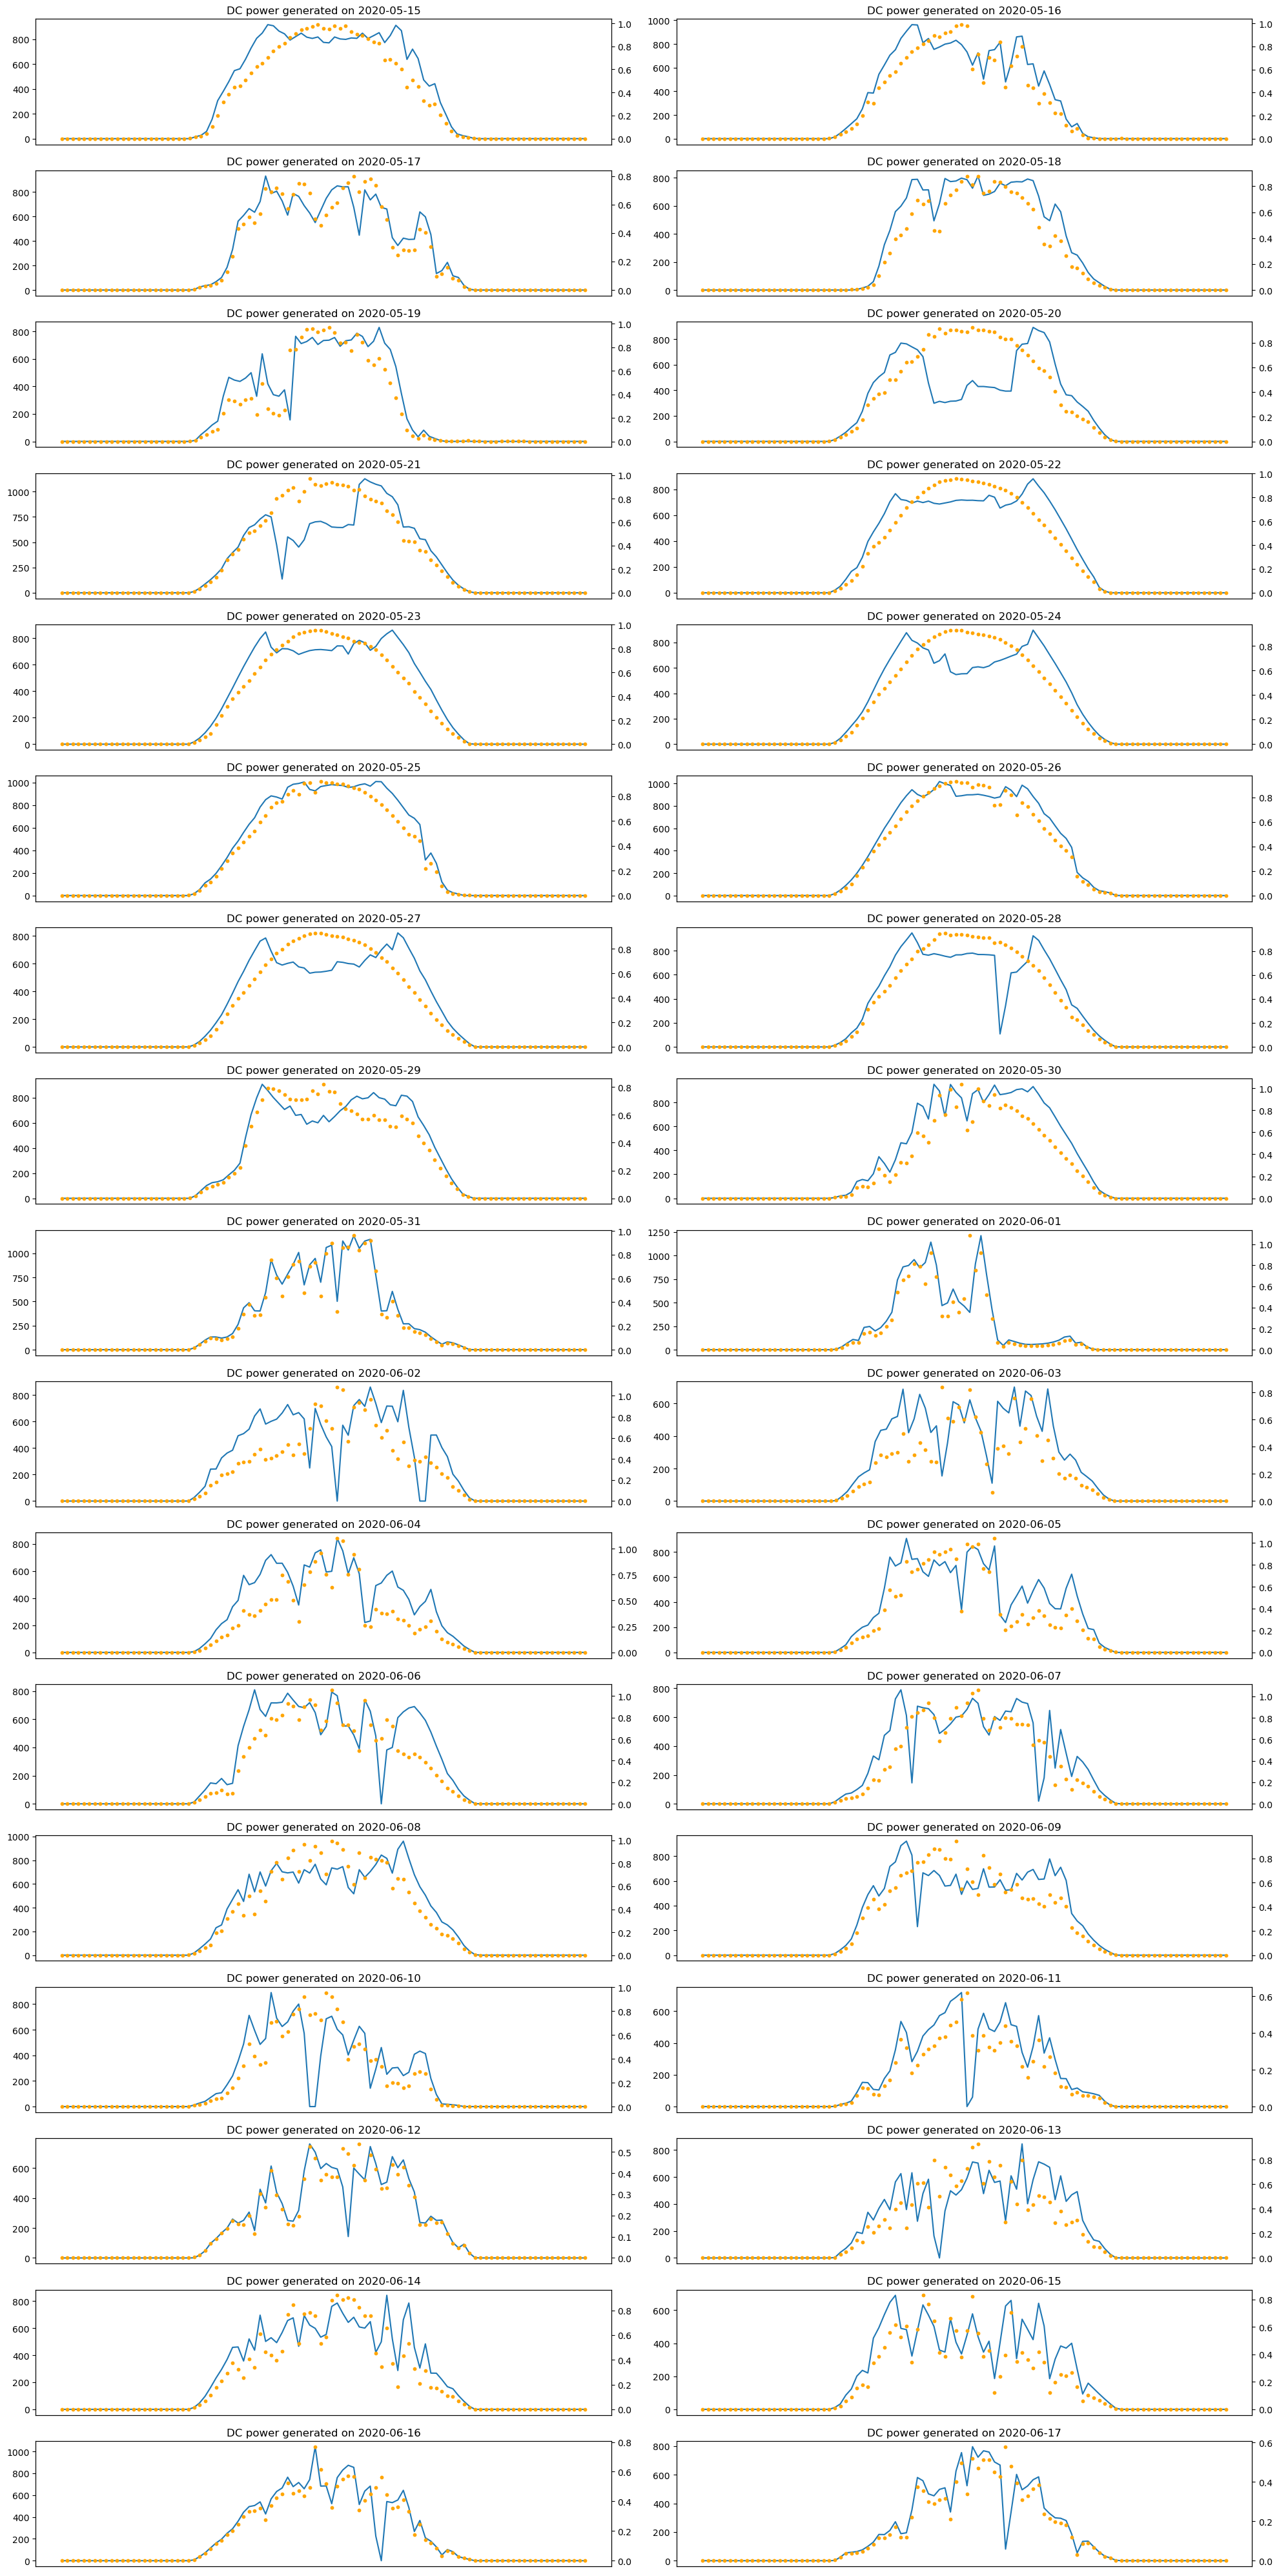

In [17]:
# get unique dates
unique_dates = generation.date.unique()

# calculate the number of rows and columns for subplots
num_rows = int(len(unique_dates)/2)
num_cols = 2

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 40))

axs = axs.flatten()

for i, date in enumerate(unique_dates):

    aux = generation[generation.date == date].groupby(['date', 'time']).DC_POWER.mean().reset_index()
    aux2 = full[full.date == date].groupby(['date', 'time']).IRRADIATION.mean().reset_index()
    
    axs[i].plot(aux.time.astype('str'), aux.DC_POWER, label = 'DC POWER')
    
    axs2=axs[i].twinx()
    axs2.scatter(aux.time.astype('str'), aux2.IRRADIATION, label = 'IRRADIATION', s =10, c = 'orange')
    
    axs[i].set_title(f'DC power generated on {date}')
    
    #tick locations
    #ticks = plt.xticks()[i]
    # only show one label every four ticks
    #selected_ticks = ticks[::4]
    #selected_labels = [label[:5] for label in DC.time.astype('str')][::4]
    plt.xticks([])

plt.tight_layout()
plt.show()

<AxesSubplot:>

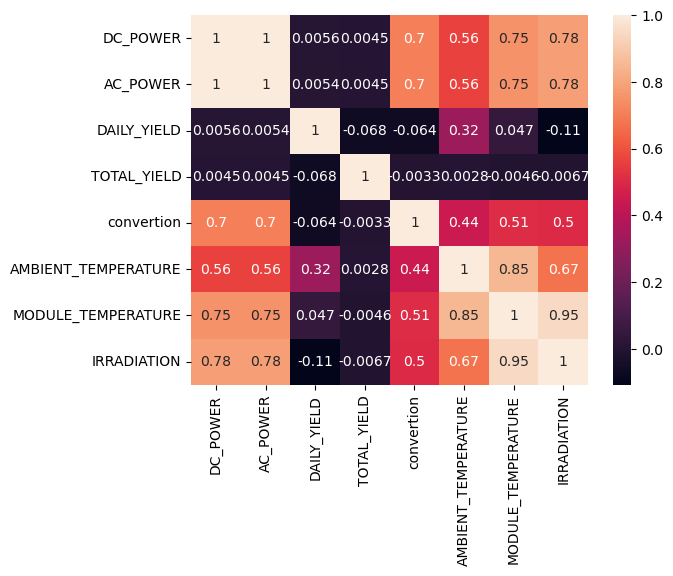

In [18]:
sns.heatmap(full[['DC_POWER', 'AC_POWER', 'DAILY_YIELD',
       'TOTAL_YIELD', 'convertion','AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']].corr(),
           annot = True)

<AxesSubplot:>

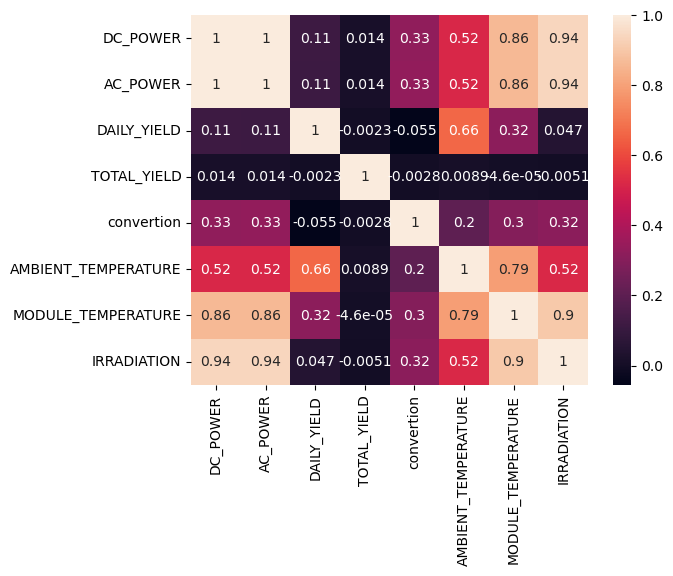

In [19]:
sns.heatmap(full[full.DC_POWER!=0][['DC_POWER', 'AC_POWER', 'DAILY_YIELD',
       'TOTAL_YIELD', 'convertion','AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']].corr(),
           annot = True)

In [20]:
from scipy.stats import pearsonr

correlation_list = []
for date in unique_dates:
    correlation = (date, pearsonr(full[full.date == date].IRRADIATION, full[full.date == date].DC_POWER)[0])
    correlation_list.append(correlation)
correlation_array = np.array(correlation_list)

clean_days = correlation_array[np.where(correlation_array[:,1]>0.93)]
clean_days

array([[datetime.date(2020, 5, 31), 0.9663046437715203],
       [datetime.date(2020, 6, 1), 0.9366232701820181],
       [datetime.date(2020, 6, 12), 0.9421879635822507],
       [datetime.date(2020, 6, 17), 0.9336529186013414]], dtype=object)

In [21]:
correlation_array[np.where(correlation_array[:,1]==np.max(correlation_array[:,1]))][0,0]

datetime.date(2020, 5, 31)

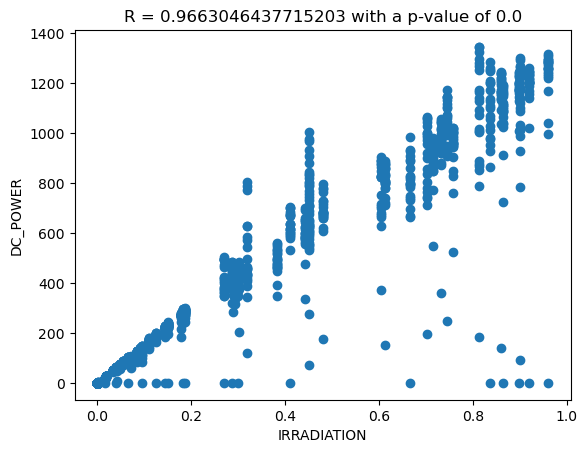

In [22]:
day = correlation_array[np.where(correlation_array[:,1]==np.max(correlation_array[:,1]))][0,0]
correlation_coefficient, p = pearsonr(full[full.date==day]['IRRADIATION'], full[full.date==day]['DC_POWER'])

plt.scatter(full[full.date == day]['IRRADIATION'], full[full.date == day]['DC_POWER'])
plt.title(f'R = {correlation_coefficient} with a p-value of {p}')
plt.xlabel('IRRADIATION')
plt.ylabel('DC_POWER')
plt.show()

In [23]:
## I am assuming that days with high linear correlation between irradiation and DC power (r>0.93)
## are the best to train the model --> they have few records that diverge from "normal" behaviour

training_dates_linreg = clean_days[:,0]

from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

train = full[full.date.isin(training_dates_linreg)]
#X_train = train['IRRADIATION'].values.reshape(-1,1)
#y_train = train['DC_POWER'].values.reshape(-1,1)

test = full[~full.date.isin(training_dates_linreg)]
#X_test = test['IRRADIATION'].values.reshape(-1,1)
#y_test = test['DC_POWER'].values.reshape(-1,1)

In [24]:
linreg.fit(train.IRRADIATION.values.reshape(-1,1), train.DC_POWER.values.reshape(-1,1))

LinearRegression()

In [25]:
y_pred = linreg.predict(test.IRRADIATION.values.reshape(-1,1))
test['prediction'] = y_pred
test['residuals'] = test.prediction-test.DC_POWER

full['prediction'] = linreg.predict(full.IRRADIATION.values.reshape(-1,1))
full['residuals'] = full.prediction-full.DC_POWER

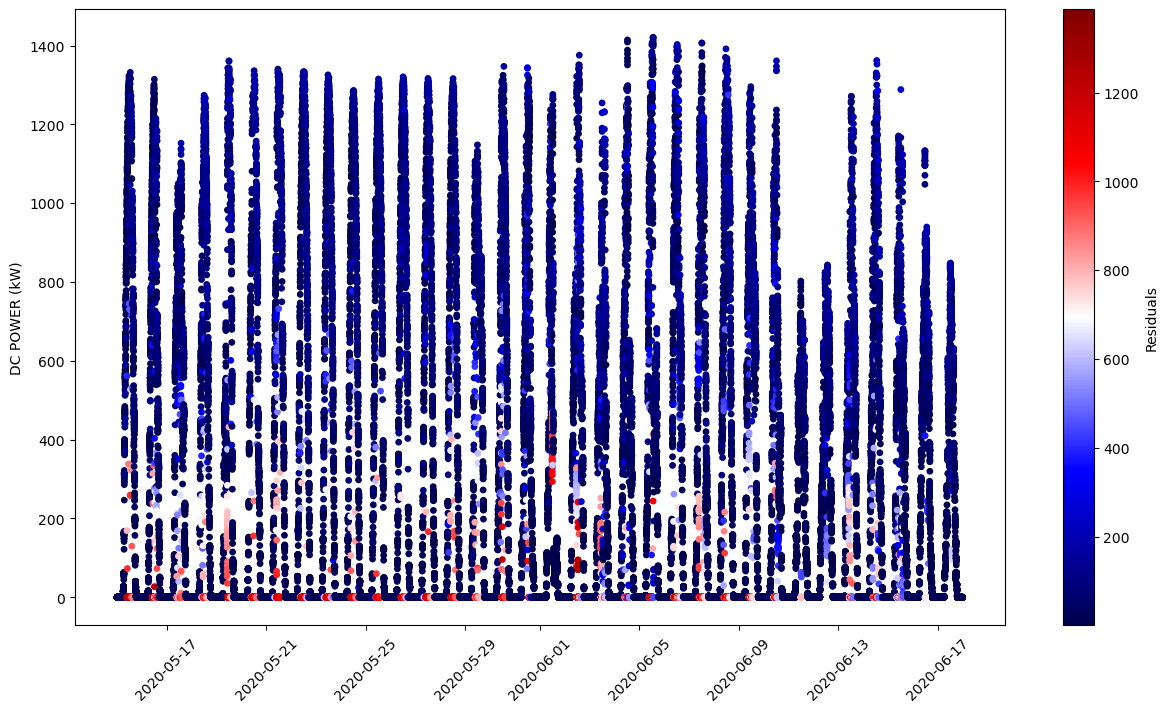

In [26]:
res = abs(full.residuals)
cmap = plt.get_cmap('seismic')

plt.figure(figsize=(15,8))
scatter = plt.scatter(full.DATE_TIME, full.DC_POWER, c=res, cmap=cmap, s = 15)
cbar = plt.colorbar(scatter)
cbar.set_label('Residuals') 

plt.ylabel('DC POWER (kW)')
plt.xticks(ha = 'center', rotation=45)
plt.show()

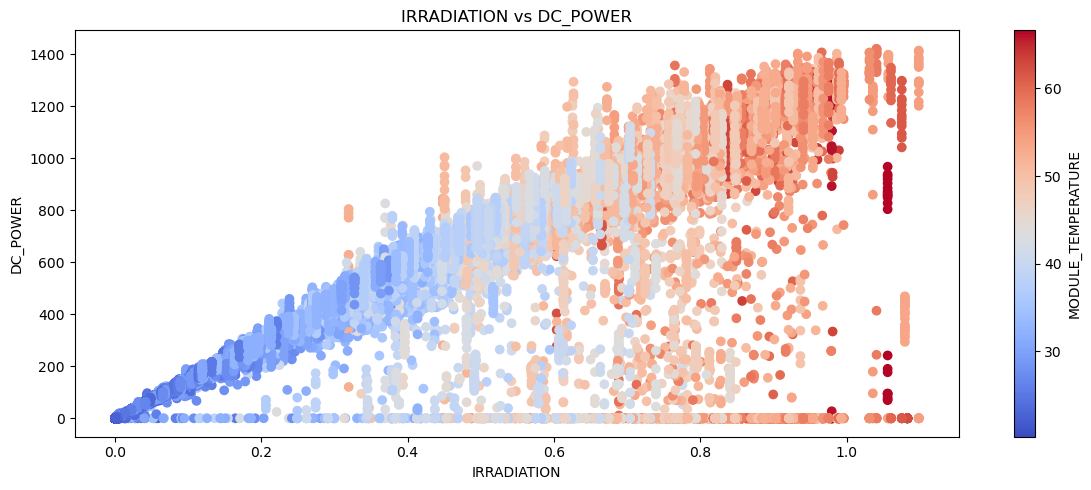

In [27]:
### plot DC POWER vs IRRADIATION TO SEE HOW MUCH THEY ARE NOT LINEARLY DEPENDENT depending on the module_temperature
fig, ax = plt.subplots(figsize=(12,5))
cmap = plt.get_cmap('coolwarm')

temperature = full['MODULE_TEMPERATURE']

# Scatter plot for all data
scatter_all = ax.scatter(full['IRRADIATION'], full['DC_POWER'], c = temperature, cmap = cmap)
ax.set_title('IRRADIATION vs DC_POWER')
ax.set_xlabel('IRRADIATION')
ax.set_ylabel('DC_POWER')
cbar_all = plt.colorbar(scatter_all, ax=ax, orientation='vertical')
cbar_all.set_label('MODULE_TEMPERATURE')


# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

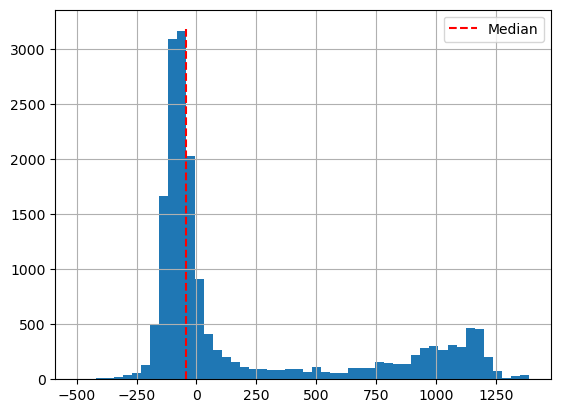

In [28]:
residuals_median = full[(full.time>=time(9,0,0))&(full.time<=time(15,0,0))].residuals.median()

plt.hist(full[(full.time>=time(9,0,0))&(full.time<=time(15,0,0))].residuals, bins=50)
plt.vlines(residuals_median, ymin=0, ymax=3200, color = 'red', label='Median', linestyle = '--')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
## calculate z-score on the residuals

full['z_score'] = abs((full.residuals-full.residuals.mean())/full.residuals.std())
full['flag_outlier'] = np.where(full['z_score']>=1.5, 1, 0)

In [30]:
full['flag_outlier'].value_counts()

flag_outlier
0    63261
1     4437
Name: count, dtype: int64

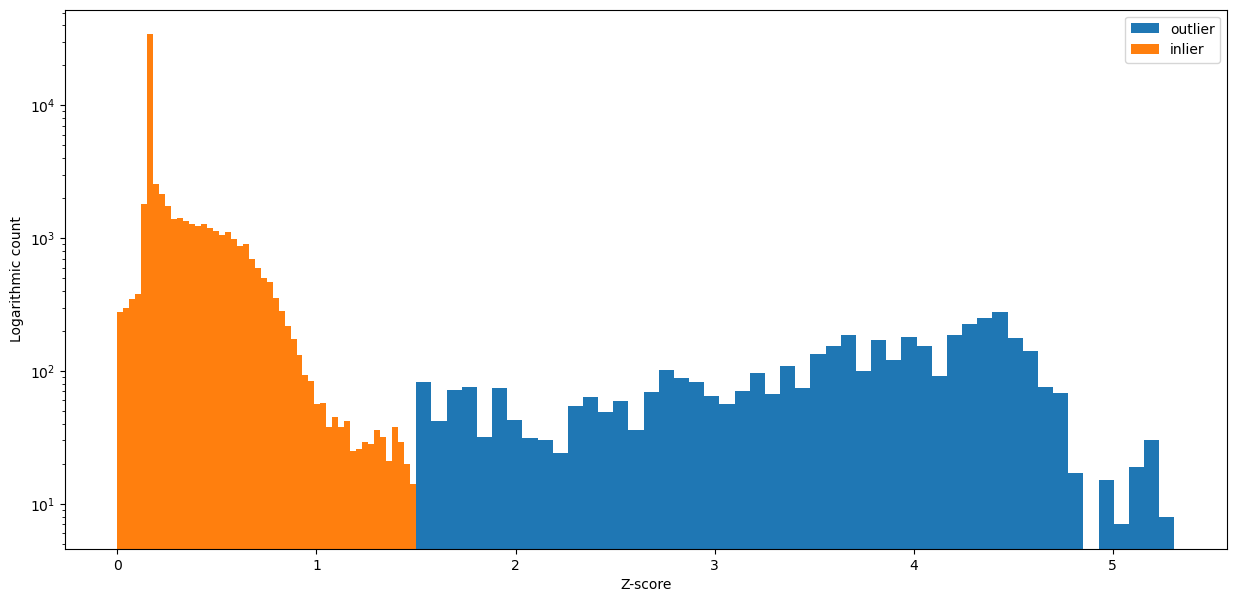

In [31]:
plt.figure(figsize=(15,7))
outlier = full[full['flag_outlier'] == 1]
inlier = full[full['flag_outlier'] == 0]
plt.hist(outlier['z_score'], bins=50, label = 'outlier', log = True)
plt.hist(inlier['z_score'], bins=50, label = 'inlier', log = True)
plt.ylabel('Logarithmic count')
plt.xlabel('Z-score')
plt.legend()
plt.show()

In [32]:
worst_days = correlation_array[np.where(correlation_array[:,1]<0.7)][:,0]
worst_days

array([datetime.date(2020, 5, 20), datetime.date(2020, 5, 27),
       datetime.date(2020, 6, 2), datetime.date(2020, 6, 7)], dtype=object)

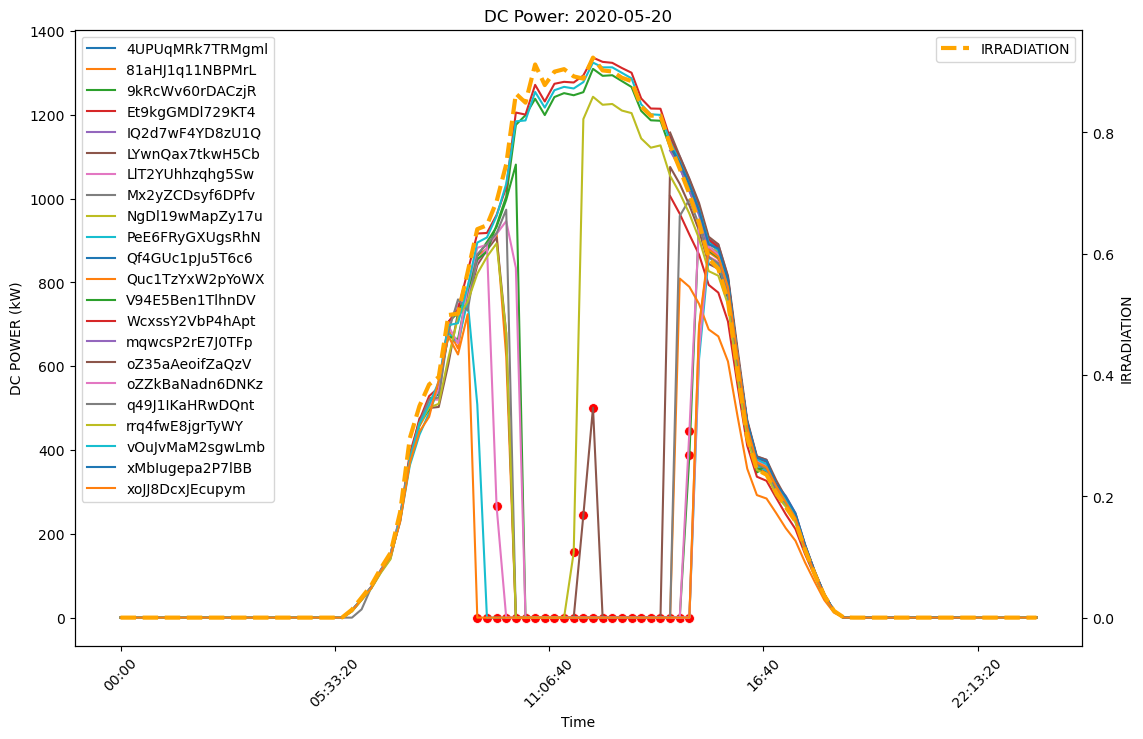

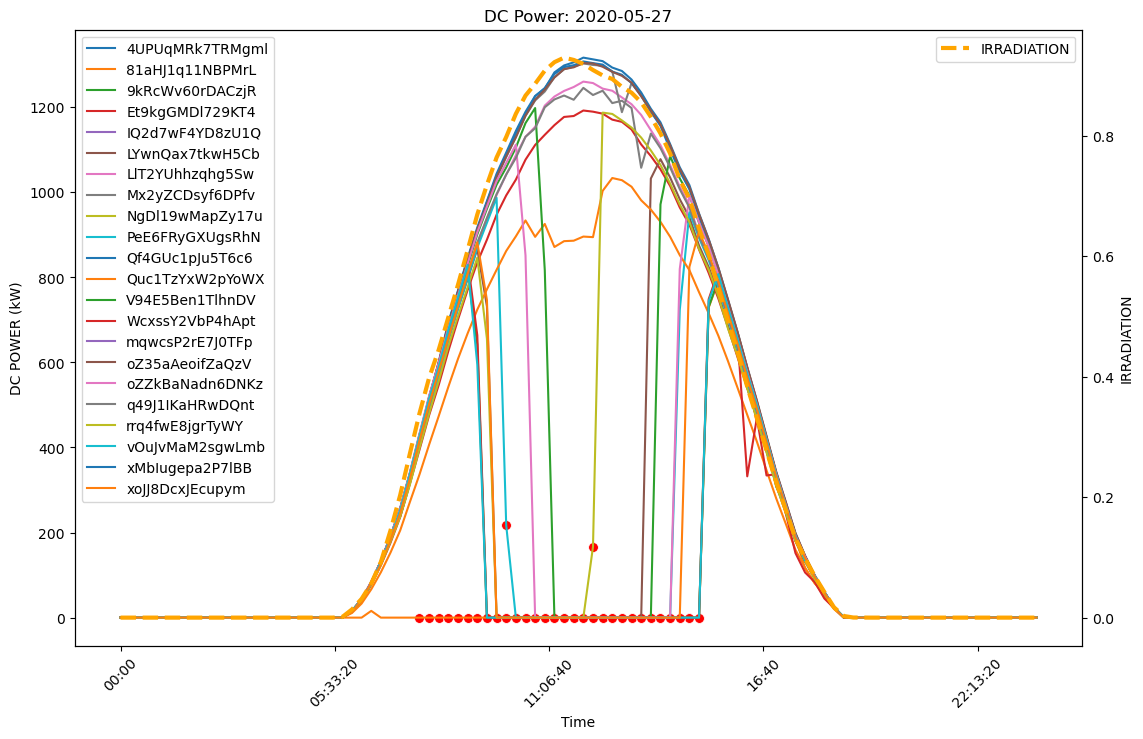

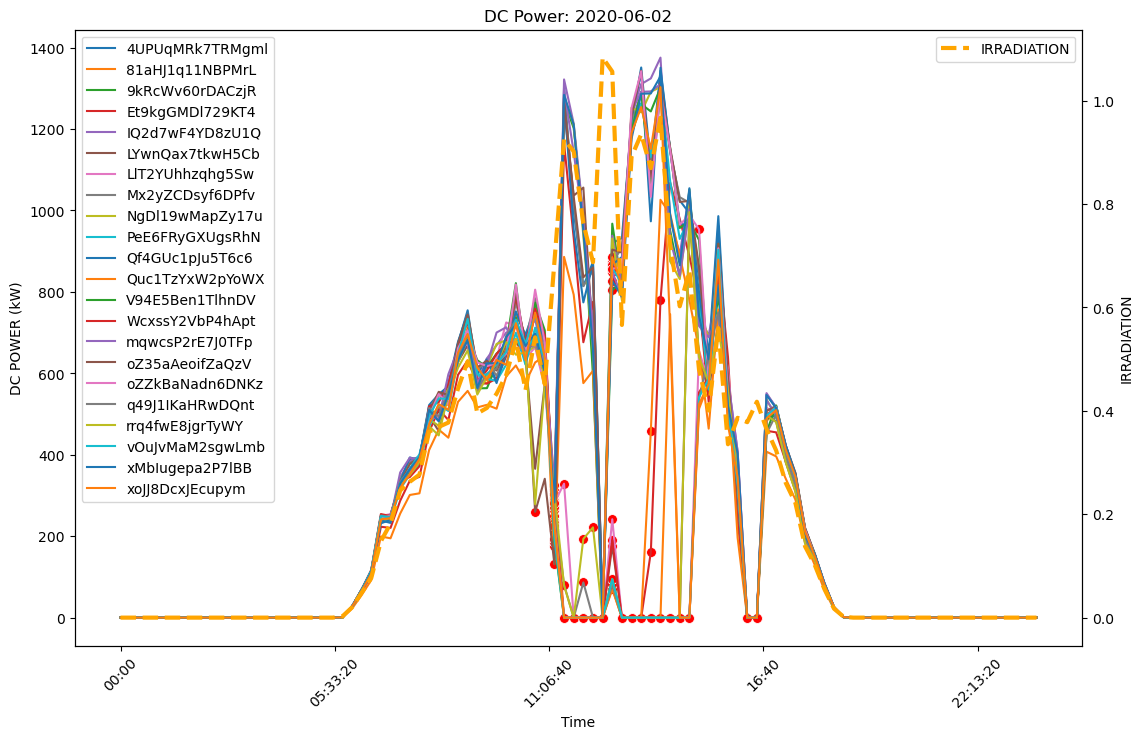

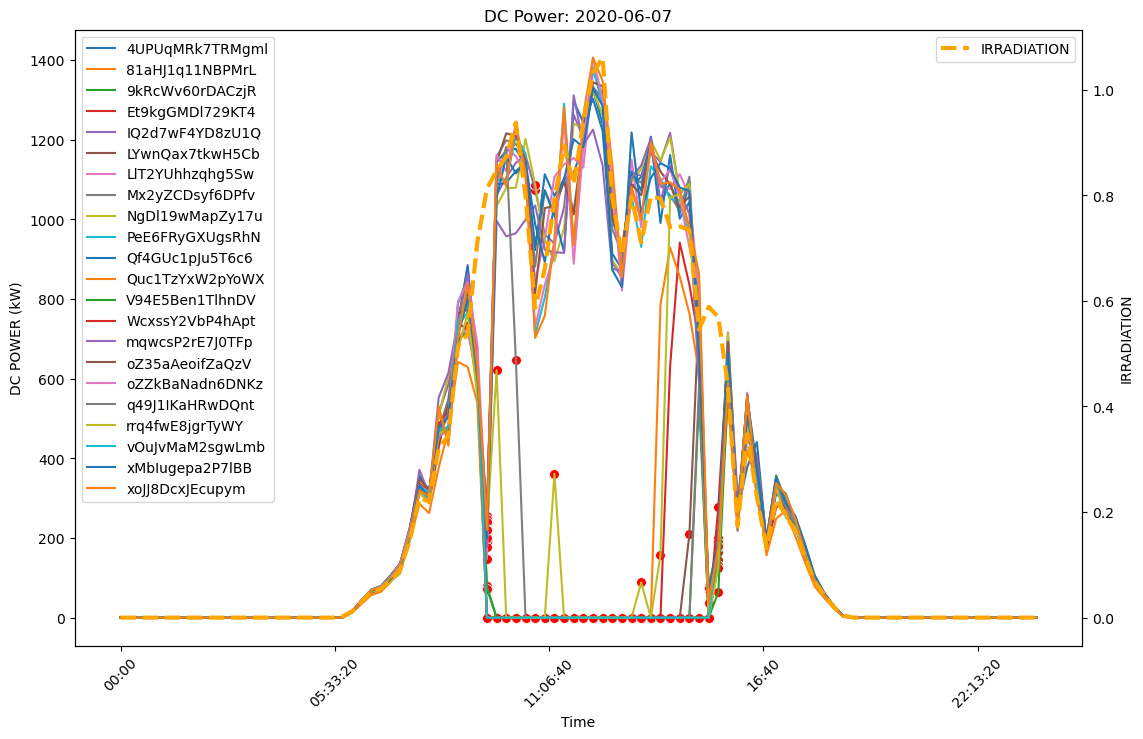

In [33]:
## red dots pin point records flagged as outliers based on their Z-score

import datetime

for date in worst_days:
    date_data=full[(full.date==date)]

    fig, ax1 = plt.subplots(figsize=(13, 8))
    
    for panel in full.SOURCE_KEY_x.unique():
        panel_data=date_data[date_data.SOURCE_KEY_x==panel]
        ax1.plot(panel_data.time, panel_data.DC_POWER, label=panel)     
        sns.scatterplot(x ='time', y = 'DC_POWER', data = panel_data[panel_data.flag_outlier==1], marker='o', s = 50, color = 'red', ax = ax1)

    ax1.set_xlabel('Time')
    ax1.set_ylabel('DC POWER (kW)')
    ax1.set_title(f'DC Power: {date}')
    ax1.legend(loc='upper left')
    ax1.tick_params(axis='x', rotation=45)
    
    ax2 = ax1.twinx() 
    ax2.plot(date_data.time, date_data.IRRADIATION, color='orange', label='IRRADIATION', linestyle='--', linewidth=3)
    ax2.set_ylabel('IRRADIATION')
    ax2.legend(loc='upper right')


plt.show()

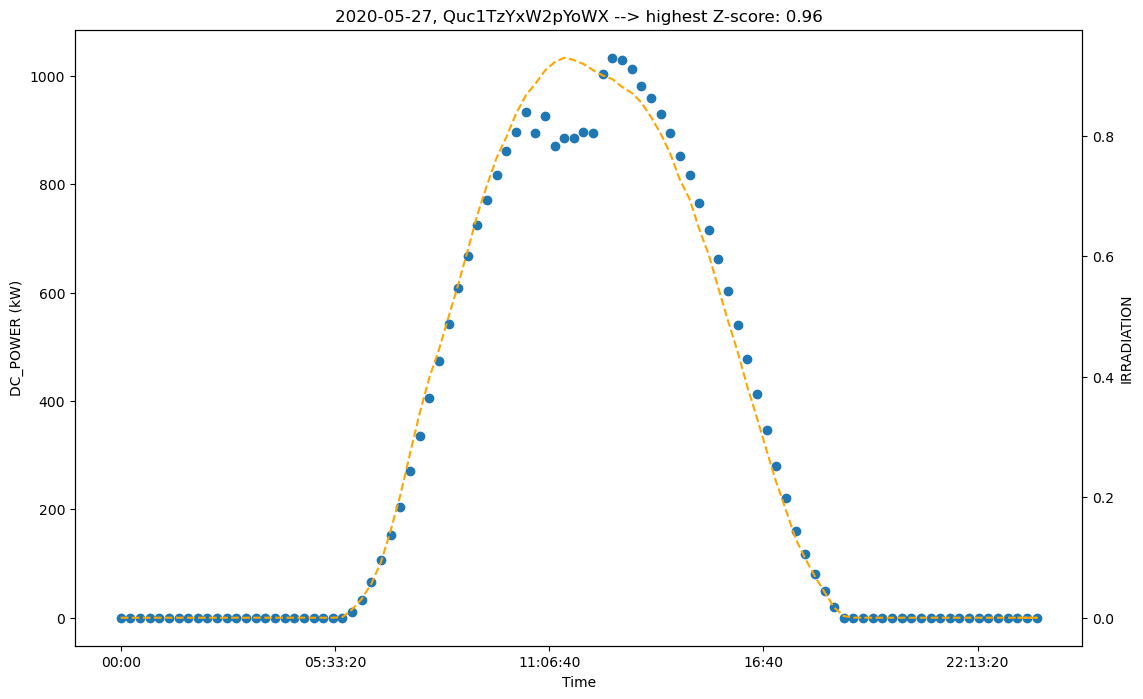

In [34]:
## focus on a suspicious looking plot from above (z-score is low, <1)

plt.figure(figsize=(13,8))
date = datetime.date(2020, 5, 27)
inverter = 'Quc1TzYxW2pYoWX'
specific_data = full[(full.SOURCE_KEY_x==inverter)&(full.date==date)]
z_score_max = specific_data.z_score.max()
plt.scatter(full.time.unique(), specific_data.DC_POWER)
plt.xlabel('Time')
plt.ylabel('DC_POWER (kW)')

ax2 = plt.gca().twinx()
ax2.plot(full.time.unique(), specific_data.IRRADIATION, color='orange', linestyle='--', label='IRRADIATION')
ax2.set_ylabel('IRRADIATION')

plt.title(f'{date}, {inverter} --> highest Z-score: {z_score_max:.2f}')
plt.show()